# Logistic Regression on PYNQ-Z1
### Introduction:

This example considers Scikit-Learn's Logistic Regression for linear classification. You will see that a speedup can be achieved by offloading decision_function(x), which contains the main computation, to a custom-built FPGA accelerator running on PYNQ-Z1. We use the PynqLogisticRegression class (in pynq_sklearn/linear_model/linear_classification.py) to load a hybrid library, which contains the bitstream and low-level C API. This class inherits from sklearn.linear_model.LogisticRegression and overrides decision_function(x) when hw_accel=True.

### Hybrid Library:
We will use **lr_multi** which contains the bitstream, C API and python attributes for the PynqLogisticRegression class. **Note:** This library supports a fixed size FPGA accelerator with **n_features=32** and **n_classes=10** (i.e. the problem size/shape is not customisable post bitstream).

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from pynq_sklearn import HybridLibrary, Registry

lib = Registry.load("lr_multi")
print(lib)

HybridLibrary(): {'bitstream': 'multi.bit', 'library': 'libmulti.so', 'dma_sg': False, 'pipe': False, 'c_callable': ' void _p0_LinReg_1_noasync(int *x, int a[320], int b[10], int *output, int datalen); ', 'input_width': 32, 'output_width': 10}


### Hardware Accelerator:

For prediction, Logistic Regression calls "decision_function(x)" which implements the simple linear function given here:
### $$y(x) = A\textbf{x} + b$$

-  x - input array (n_samples, n_features)<br>
-  y - output array (n_samples,)<br>
-  A - weight matrix (n_features, n_classes) <br>
-  b - offset (n_classes,)<br>

<img src="imgs/decision_function.jpg">


### Generate Dataset:
We generate a dataset with **n_features=32** and **n_classes=10**, and plot our training set clusters.

In [2]:
import numpy as np
from sklearn import datasets
import time

# Generate dataset of Ints
X, y = datasets.make_blobs(n_samples=5000, n_features=32, centers=10, cluster_std=8, random_state=43)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1000, random_state=11)

To visualise the dataset, we use TSNE to project points from a high-dimensional space (n_features=32) to a 2D plane. Here, we can see 10 distinct clusters/classes. 

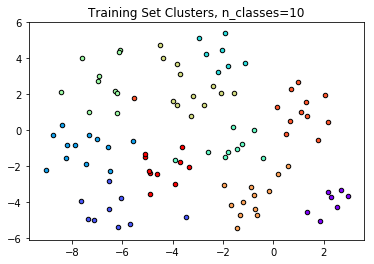

In [3]:
%matplotlib inline
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=0)
X = tsne.fit_transform(X_train[:100])
Y = y_train[:100]

plt.figure()
plt.title("Training Set Clusters, n_classes=10")

# Plot also the training points
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
for i, color in zip(np.arange(10), colors):
    idx = np.where(Y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=color,
                edgecolor='black', s=20)
plt.show()

### PYNQ Logistic Regression:
Here we will demonstrate a typical machine learning flow for training a model in software and deploying in hardware. We combine the productivity of the entire Scikit-learn ecosystem with the performance of custom hardware.

##### 1. Fit a Logistic Regression model
We import the PynqLogisticRegression model. This class inherits all the functionality of Scikit-learn's LogisticRegression class, and can optionally deploy a fitted model on the PYNQ-Z1 FPGA.   

In [4]:
from pynq_sklearn.linear_model import PynqLogisticRegression

model = PynqLogisticRegression(hw=lib, fit_intercept=True)
model.fit(X_train, y_train)

##### 2. FPGA compatible copy of X_test
Our FPGA accelerator expects 32-bit fixed point numbers (with 20 fractional bits). We also copy the array into physical contiguous memory to avoid expensive virtual address mapping. 

**Note:** This last step is mandatory for bitstreams that assume the input is physical contiguous. For bitstreams which use the scatter-gather DMA, the hybrid library will map virtual addresses within the function call.

In [5]:
FRAC_WIDTH = 20
X_test_hw = (X_test*(1<<FRAC_WIDTH)).astype(np.int32)
X_test_hw = model.copy_array(X_test_hw, dtype=np.int32) # allocates X_test_hw to contiguous memory

##### 3. With hw_accel=True, deploy prediction on the FPGA 

In [6]:
model.hw_accel = True
y_pred = model.predict(X_test_hw)

##### 3. Alternatively, deploy in SW

In [7]:
model.hw_accel=False
y_pred_sw = model.predict(X_test)

##### 4. Verify equivalence
We should get approximately the same classification performance. Any errors/differences are attributable to fixed point rounding errors in the FPGA.

In [8]:
print("Exactly equal =",np.array_equal(y_pred,y_pred_sw))
print("Differences =", np.count_nonzero((y_pred-y_pred_sw)))

Exactly equal = True
Differences = 0


##### 5. Evaluate the results
We have access to Scikit-learn's entire library for evaluating and scoring machine learning models. We can perform score directly on our HW accelerator model, or we can create a custom scoring function to be used separately.

In [9]:
model.hw_accel=True
acc = model.score(X_test_hw, y_test) 
print("Mean Accuracy =", acc) 

Mean Accuracy = 0.965


In [10]:
from sklearn.metrics import classification_report

def custom_scorer(y, y_pred):
    # We can put anything in here.
    class_names = ["Class%d"%(i) for i in range(10)]
    return classification_report(y, y_pred, target_names=class_names)

print( custom_scorer(y_test, y_pred))

             precision    recall  f1-score   support

     Class0       0.99      0.98      0.99       106
     Class1       0.97      0.97      0.97       106
     Class2       0.95      0.91      0.93       104
     Class3       0.98      0.99      0.98       119
     Class4       0.95      0.99      0.97        94
     Class5       0.95      0.95      0.95        95
     Class6       0.93      0.96      0.94        97
     Class7       0.99      0.96      0.97       101
     Class8       0.99      0.99      0.99        93
     Class9       0.95      0.94      0.95        85

avg / total       0.97      0.96      0.96      1000



Refer [here](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html) for classification report details. 

##### 6. Performance Comparison
Using the FPGA, we can observe a small speedup over a software-only implementation.

In [11]:
import timeit
number=200

model.hw_accel=True
def hwresp():
    y=model.predict(X_test_hw)
    return

hw_time = timeit.timeit(hwresp,number=number)

model.hw_accel=False
def swresp():
    y=model.predict(X_test)
    return

sw_time = timeit.timeit(swresp,number=number)

print("Time taken by sklearn", number,"times",sw_time)
print("Time taken by sklearn+fpga", number,"times",hw_time)
print("HW Speedup = %.2fx"%(sw_time/hw_time))

Time taken by sklearn 200 times 1.246218567000028
Time taken by sklearn+fpga 200 times 0.4008721110000124
HW Speedup = 3.11x


However, if we only compare the accelerated function (i.e. model.decision_function) then we can observe an even better speedup. This occurs because model.predict() includes additional operations for separating regression results into classes.

In [12]:
import timeit
number=200

model.hw_accel=True
def hwresp():
    y=model.decision_function(X_test_hw)
    return

hw_time = timeit.timeit(hwresp,number=number)

model.hw_accel=False
def swresp():
    y=model.decision_function(X_test)
    return

sw_time = timeit.timeit(swresp,number=number)

print("Time taken by sklearn", number,"times",sw_time)
print("Time taken by sklearn+fpga", number,"times",hw_time)
print("HW Speedup = %.2fx"%(sw_time/hw_time))

Time taken by sklearn 200 times 1.1400765300001012
Time taken by sklearn+fpga 200 times 0.13984620600001563
HW Speedup = 8.15x


##### 7. Reset
It is good practise to free all CMA buffers when we are finished.

In [13]:
model.xlnk.xlnk_reset()